In [53]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, make_scorer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier

from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier, XGBRFClassifier

import optuna

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")


In [2]:
data_transactions = pd.read_json("../transactions.json", lines=True)
data_merchants = pd.read_csv("../merchants.csv")
data_users = pd.read_csv("../users.csv")

In [3]:
location_df = pd.json_normalize(data_transactions['location'])
location_df.columns = ['latitude', 'longitude']

data_transactions = data_transactions.drop(columns=['location']).join(location_df)

In [4]:
df = data_transactions.merge(data_merchants, on='merchant_id', how='left').merge(data_users, on='user_id', how='left')

In [5]:
df["education"] = df["education"].fillna("No Education")  # nan -> wykształcenie niższe niż średnie
df["education"].value_counts()

education
PhD             103760
Master          100526
Bachelor        100325
High School      98823
No Education     96566
Name: count, dtype: int64

In [78]:
df_cleaned = df.drop(columns = ["transaction_id", "currency"])

In [79]:
# Sort by user_id and timestamp for user-based features
df_cleaned = df_cleaned.sort_values(by=["user_id", "timestamp"])
df_cleaned = df_cleaned.reset_index(drop=True) # Ensure unique, sequential index

# User fraud history
df_cleaned['temp_cumulative_fraud'] = df_cleaned.groupby('user_id')['is_fraud'].cumsum()
shifted_cumulative_fraud = df_cleaned.groupby('user_id')['temp_cumulative_fraud'].shift(1)
df_cleaned['user_has_fraud_history'] = shifted_cumulative_fraud.fillna(0).gt(0).astype(int)
df_cleaned = df_cleaned.drop(columns=['temp_cumulative_fraud'])

# User transaction count
df_cleaned["dummy"] = np.ones(len(df_cleaned))
df_cleaned["users_transaction_count"] = df_cleaned.groupby("user_id")["dummy"].cumsum().astype(int)
df_cleaned = df_cleaned.drop(columns=["dummy"])

# Time since last transaction for user
df_cleaned['time_since_last_transaction_user'] = df_cleaned.groupby('user_id')['timestamp'].diff().dt.days
df_cleaned['time_since_last_transaction_user'] = df_cleaned['time_since_last_transaction_user'].fillna(0).astype(int)

# Transaction amount statistics for user
user_amount_mean_shifted = df_cleaned.groupby('user_id')['amount'].transform(lambda x: x.expanding().mean().shift(1))
user_amount_std_shifted = df_cleaned.groupby('user_id')['amount'].transform(lambda x: x.expanding().std().shift(1))
df_cleaned['transaction_amount_std_from_user_mean'] = (df_cleaned['amount'] - user_amount_mean_shifted) / user_amount_std_shifted
df_cleaned['transaction_amount_std_from_user_mean'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_cleaned['transaction_amount_std_from_user_mean'].fillna(0, inplace=True)

# Days since signup
df_cleaned['signup_date'] = pd.to_datetime(df_cleaned['signup_date'])
df_cleaned['transaction_date'] = pd.to_datetime(df_cleaned['timestamp'], unit='ms')
df_cleaned['days_since_signup'] = (df_cleaned['transaction_date'] - df_cleaned['signup_date']).dt.total_seconds() / (24*3600)

# Transaction time features
df_cleaned['transaction_hour'] = df_cleaned['transaction_date'].dt.hour
df_cleaned['is_transaction_night'] = ((df_cleaned['transaction_hour'] >= 0) & (df_cleaned['transaction_hour'] < 6)).astype(int)

# Helper function for rolling count
def rolling_count(series, window):
    # series is a DataFrame with 'transaction_date'
    return series['transaction_date'].apply(
        lambda x: ((series['transaction_date'] >= (x - pd.Timedelta(window))) & (series['transaction_date'] < x)).sum()
    )

# Calculate transactions in the last 1 hour for each user
df_cleaned['transactions_last_1h_user'] = (
    df_cleaned.groupby('user_id', group_keys=False)
    .apply(lambda group: rolling_count(group, '1h'))
    .sort_index()
)

# Calculate transactions in the last 24 hours for each user
df_cleaned['transactions_last_24h_user'] = (
    df_cleaned.groupby('user_id', group_keys=False)
    .apply(lambda group: rolling_count(group, '24h'))
    .sort_index()
)

# Average amount of last 5 transactions for user
df_cleaned['avg_amount_last_5_tx_user'] = df_cleaned.groupby('user_id')['amount'].transform(lambda x: x.rolling(window=5, min_periods=1).mean().shift(1))
df_cleaned['avg_amount_last_5_tx_user'].fillna(0, inplace=True)

# Sort by merchant_id and timestamp for merchant-based features
df_cleaned = df_cleaned.sort_values(by=["merchant_id", "timestamp"])
df_cleaned = df_cleaned.reset_index(drop=True) # Reset index again

# Merchant fraud history
df_cleaned['temp_cumulative_fraud'] = df_cleaned.groupby('merchant_id')['is_fraud'].cumsum()
shifted_cumulative_fraud = df_cleaned.groupby('merchant_id')['temp_cumulative_fraud'].shift(1)
df_cleaned['merchant_has_fraud_history'] = shifted_cumulative_fraud.fillna(0).gt(0).astype(int)
df_cleaned = df_cleaned.drop(columns=['temp_cumulative_fraud'])

df_cleaned = df_cleaned.sort_values(by=["user_id", "timestamp"]) # Consistent sorting
df_cleaned = df_cleaned.reset_index(drop=True) # Clean index

def _get_user_device_mode_for_transform(series):
    # Ensure numpy is imported in your notebook, e.g., import numpy as np
    modes = series.mode()
    if not modes.empty:
        return modes.iloc[0]
    return np.nan

df_cleaned['user_mode_device_temp'] = df_cleaned.groupby('user_id')['device'].transform(_get_user_device_mode_for_transform)
df_cleaned['device_changed'] = 0
has_mode_device = df_cleaned['user_mode_device_temp'].notna()
df_cleaned.loc[has_mode_device, 'device_changed'] = \
    (df_cleaned.loc[has_mode_device, 'device'] != df_cleaned.loc[has_mode_device, 'user_mode_device_temp']).astype(int)

#Change datatypes if necessary
df_cleaned['days_since_signup'] = df_cleaned['days_since_signup'].astype(int)

In [80]:
# --- 1. Temporal Pattern Features ---
df_cleaned['day_of_week'] = df_cleaned['transaction_date'].dt.dayofweek
df_cleaned['is_weekend'] = (df_cleaned['transaction_date'].dt.dayofweek >= 5).astype(int)

# User transaction velocity in last 15 minutes
df_cleaned = df_cleaned.sort_values(by=["user_id", "timestamp"]).reset_index(drop=True)
df_cleaned['user_tx_velocity_15m'] = (
    df_cleaned.groupby('user_id', group_keys=False)
    .apply(lambda group: rolling_count(group, '15m')) # Ensure rolling_count is defined
    .sort_index() # Re-aligns series from apply with df_cleaned's index
).astype(int)


# --- 2. High-Risk Merchant Features ---
df_cleaned = df_cleaned.sort_values(by=["merchant_id", "timestamp"]).reset_index(drop=True)

df_cleaned['merchant_past_tx_count'] = df_cleaned.groupby('merchant_id').cumcount()
df_cleaned['merchant_past_fraud_count'] = df_cleaned.groupby('merchant_id')['is_fraud'].transform(lambda x: x.shift(1).expanding().sum()).fillna(0).astype(int)

df_cleaned['merchant_past_fraud_rate'] = (df_cleaned['merchant_past_fraud_count'] / (df_cleaned['merchant_past_tx_count'] + 1e-6))
df_cleaned['merchant_past_fraud_rate'].fillna(0, inplace=True)
df_cleaned['merchant_past_fraud_rate'].replace([np.inf, -np.inf], 0, inplace=True)

df_cleaned['merchant_avg_amount_hist'] = df_cleaned.groupby('merchant_id')['amount'].transform(lambda x: x.shift(1).expanding().mean()).fillna(0)

df_cleaned['amount_vs_merchant_avg_ratio'] = (df_cleaned['amount'] / (df_cleaned['merchant_avg_amount_hist'] + 1e-6))
df_cleaned['amount_vs_merchant_avg_ratio'].fillna(0, inplace=True)
df_cleaned['amount_vs_merchant_avg_ratio'].replace([np.inf, -np.inf], 0, inplace=True)


# --- 3. Cardholder Behavior Anomaly Features ---
df_cleaned = df_cleaned.sort_values(by=["user_id", "timestamp"]).reset_index(drop=True)

if 'avg_amount_last_5_tx_user' in df_cleaned.columns:
    df_cleaned['amount_vs_user_avg_5tx_ratio'] = (df_cleaned['amount'] / (df_cleaned['avg_amount_last_5_tx_user'] + 1e-6))
    df_cleaned['amount_vs_user_avg_5tx_ratio'].fillna(0, inplace=True)
    df_cleaned['amount_vs_user_avg_5tx_ratio'].replace([np.inf, -np.inf], 0, inplace=True)
else:
    print("Warning: Column 'avg_amount_last_5_tx_user' not found. Skipping 'amount_vs_user_avg_5tx_ratio' feature.")

df_cleaned['is_new_merchant_for_user'] = (df_cleaned.groupby(['user_id', 'merchant_id']).cumcount() == 0).astype(int)

# Final sort (consistent with previous processing)
df_cleaned = df_cleaned.sort_values(by=["user_id", "timestamp"]).reset_index(drop=True)

# Clean up temporary columns
df_features_added = df_cleaned.drop(columns=['transaction_date', 'signup_date'])

In [81]:
enc = OrdinalEncoder()

X = df_features_added.drop(columns=["is_fraud"])
y = df_features_added["is_fraud"]

X = pd.DataFrame(enc.fit_transform(X), columns=X.columns)

X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True
)

# Undersample only the training data
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train_orig, y_train_orig)

In [82]:
# Custom cost-based scoring function

def custom_cost_function(y_true, y_pred, cost_fn=10, cost_fp=3):
    y_true_arr = np.asarray(y_true)
    y_pred_arr = np.asarray(y_pred)
    fn_count = np.sum((y_true_arr == 1) & (y_pred_arr == 0))
    fp_count = np.sum((y_true_arr == 0) & (y_pred_arr == 1))
    return fn_count * cost_fn + fp_count * cost_fp

custom_scorer = make_scorer(custom_cost_function, greater_is_better=False)

# Recursive feature elimination with CV, supporting custom scorer

def rfe_with_cv(
    model_prototype,
    X: pd.DataFrame,
    y: pd.Series,
    n_splits: int = 3,
    scoring=custom_scorer,
    random_state: int = 42
):
    features = X.columns.tolist()
    best_score = np.inf  # lower cost is better
    best_features = features.copy()
    history = {}

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    while features:
        model = clone(model_prototype)
        scores = cross_val_score(
            model,
            X[features],
            y,
            cv=cv,
            scoring=scoring,
            n_jobs=-1
        )
        mean_score = np.mean(scores)
        history[len(features)] = mean_score

        if mean_score < best_score or (
            np.isclose(mean_score, best_score) and len(features) < len(best_features)
        ):
            best_score = mean_score
            best_features = features.copy()

        if len(features) == 1:
            break

        model_full = clone(model_prototype)
        model_full.fit(X[features], y)
        importances = pd.Series(
            model_full.feature_importances_,
            index=features
        )
        least_imp = importances.idxmin()
        features.remove(least_imp)

    print(f"RFE complete: lowest cost={best_score:.2f} with {len(best_features)} features.")
    return best_features, history

# Run RFE on balanced training data
xgb_prototype = XGBRFClassifier()
best_feats, rfe_history = rfe_with_cv(xgb_prototype, X_train, y_train)


RFE complete: lowest cost=-61477.33 with 1 features.


Now with reduce feature size lets run Optuna with Stratified KFold again to tune the final model

In [83]:
# Use only the RFE-selected features
X_rfe = X_train[best_feats]

def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "n_jobs": -1,
        "eval_metric": "logloss",
        "use_label_encoder": False,
    }
    model = XGBRFClassifier(**params)
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    # Return mean custom cost (lower is better)
    scores = cross_val_score(model, X_rfe, y_train, cv=cv, scoring=custom_scorer, n_jobs=-1)
    return np.mean(scores)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, n_jobs=-1)

print("Best params:", study.best_params)
print("Lowest cost:", study.best_value)


[I 2025-05-16 13:21:46,624] A new study created in memory with name: no-name-c391051c-fa0f-471d-b53a-588b0dfdbd2b


[I 2025-05-16 13:21:53,147] Trial 0 finished with value: -18443.2 and parameters: {'learning_rate': 0.22859134675395346, 'n_estimators': 208, 'max_depth': 9, 'subsample': 0.7543677065922598, 'colsample_bytree': 0.7082189205448381, 'gamma': 0.023550948483496703}. Best is trial 0 with value: -18443.2.
[I 2025-05-16 13:21:53,451] Trial 4 finished with value: -18443.2 and parameters: {'learning_rate': 0.1809646338045328, 'n_estimators': 92, 'max_depth': 7, 'subsample': 0.7718990267646537, 'colsample_bytree': 0.694227778052615, 'gamma': 2.3338872156863677}. Best is trial 0 with value: -18443.2.
[I 2025-05-16 13:21:54,630] Trial 1 finished with value: -18443.2 and parameters: {'learning_rate': 0.20427575163541697, 'n_estimators': 230, 'max_depth': 7, 'subsample': 0.6505105186125423, 'colsample_bytree': 0.9918219959328158, 'gamma': 4.81918405402992}. Best is trial 0 with value: -18443.2.
[I 2025-05-16 13:21:54,752] Trial 2 finished with value: -18443.2 and parameters: {'learning_rate': 0.2609

Best params: {'learning_rate': 0.22859134675395346, 'n_estimators': 208, 'max_depth': 9, 'subsample': 0.7543677065922598, 'colsample_bytree': 0.7082189205448381, 'gamma': 0.023550948483496703}
Lowest cost: -18443.2


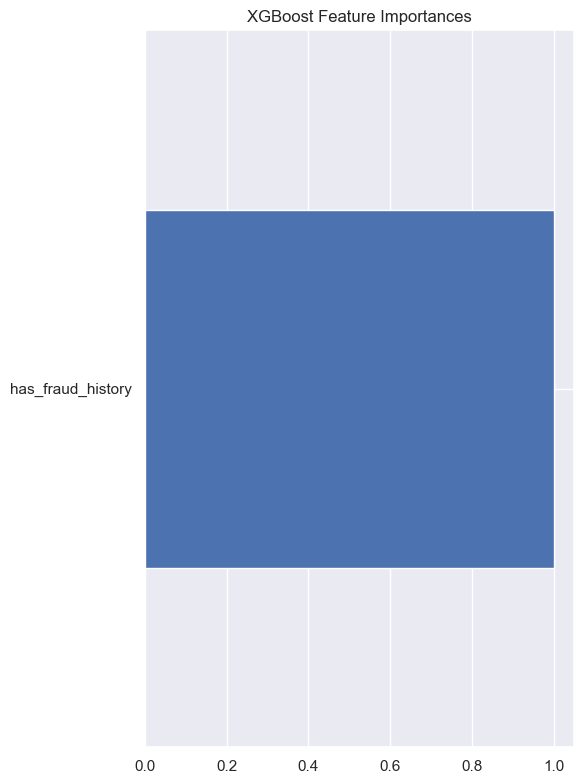

In [84]:
final_model = XGBRFClassifier(**study.best_params)
final_model.fit(X_train[best_feats], y_train)

importances = pd.Series(final_model.feature_importances_, index=best_feats)
importances.sort_values().plot(kind='barh', figsize=(6,8))
plt.title("XGBoost Feature Importances")
plt.tight_layout()
plt.show()

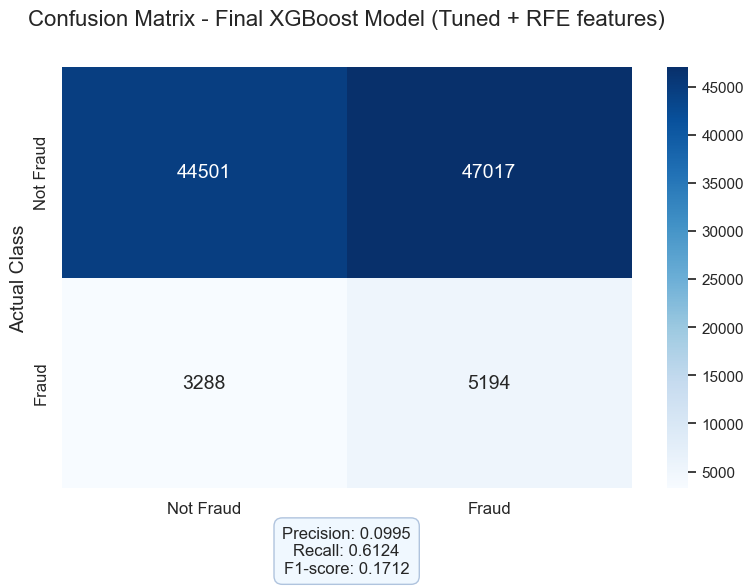

In [85]:
y_pred = final_model.predict(X_test[best_feats])

cm = confusion_matrix(y_test, y_pred)

precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

# Define class labels for the plot
class_labels = ['Not Fraud', 'Fraud']

# Plotting the confusion matrix
plt.figure(figsize=(8, 7)) # Increased figure height slightly to accommodate metrics
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels,
            annot_kws={"size": 14}) # Makes annotations easier to read

plt.title('Confusion Matrix - Final XGBoost Model (Tuned + RFE features)', fontsize=16, y=1.08) # Adjust title position
plt.ylabel('Actual Class', fontsize=14)
plt.xlabel('Predicted Class', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adding precision, recall, and F1-score text below the heatmap
metrics_text = f"Precision: {precision:.4f}\nRecall: {recall:.4f}\nF1-score: {f1:.4f}"
plt.text(0.5, -0.15, metrics_text, ha='center', va='center', transform=plt.gca().transAxes, fontsize=12,
         bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', ec='lightsteelblue', lw=1))


plt.tight_layout(rect=[0, 0.05, 1, 0.95]) # Adjust layout to prevent labels/text from overlapping, added bottom margin
plt.show()
